In [2]:
from sklearn.datasets import fetch_openml

# This library contains images of 28x28 pixels.
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

<function matplotlib.pyplot.show(close=None, block=None)>

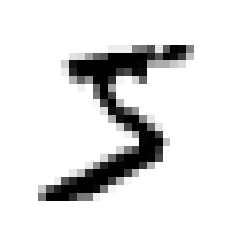

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Getting the first image (5)
# So we must reshape the pixels to fit the image.
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show

In [7]:
# We can see the image was identified as 5, from the target y[0]
y[0]

'5'

In [8]:
import numpy as np
# The label is a string, we cast it to an integer
y = y.astype(np.uint8)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
from sklearn.linear_model import SGDClassifier

# Set the random state to 42, so we can have the same reproducible results.
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


SGDClassifier(random_state=42)

In [12]:
# Since we know some_digit is 5 from earlier, we trained the model from the value. 
sgd_clf.predict([some_digit])

array([ True])

# Implementing Cross-Validation

In [13]:
# This roughly does the same thing as cross_val_score(). 
# may be needed to implement your own cross-validation.

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))


C:\Users\William\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


In [14]:
# Using sklearn's cross-validation
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
# Creating a "dumb" classifier that predicts if num is not 0.
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
# Only about 10% of the numbers are 5. so a 90% accuracy from our model above
# Shows accuracy is not the preferred performance measure for for classifiers
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

# Confusion Matrix
A better way to evaluate the performance of a classifier, as a classifier will only have true positive and true negative values
<br>
Below, you will see the visual representation of a Confusion Matrix
<br>
<img src="../img/confusion_matrix.png" alt="Confusion Matrix" style="width: 500px;"/>

In [17]:
# cross_val_predict performs k-fold cross-validation, but instead of returning the evaluation scores (like cross_val_score)
# it returns the prediction made on each test fold.
from sklearn.model_selection import cross_val_predict

y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix

# Each row represents an actual class
# Each column represents a predicted class
# 1st row (Negative class): [True Negatives: 583892 were correctly classified as non-5s, False Positives: 687 were wrongly classified as 5s]
# 2nd row (Positive class): [False Negatives: 1891 were wrongly classified as non-5s, True Positives: 3530 were correctly classified as 5s]
confusion_matrix(y_train_5, y_train_predict)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

# Precision, Recall, and F score

Precision - Accuracy of the positive predictions. <br>
(TP/(TP + FP))<br><br>
Recall - Ratio of positive instances that are correctly detected by the classifier. <br>
(TP/(TP + FN)) <br><br>

F1 score - precision and recall combined into one metric, known as the harmonic mean. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. <br>
(TP/(TP + ((FN+FP)/2)))  <br>
or <br>
(2/((1/Precision) + (1/recall))) <br>
or <br>
(2 * ((precision*recall)/(precision+recall))) <br><br>

Sometimes you should care more about precision and other times recall. For example, if you trained a classifier to detect videos that are safe for kids, you would prefer a classifier that rejects many good videos (low recall). But keep only safe ones (high precision). Rather than a classifier that has a much higher recall but lets a fewreally bad videos show up in your product.<br><br>

Suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precisiom but as long as it has 99% recall(the guards may get a few false alerts, but almost all shoplifters would get caught).

In [22]:
from sklearn.metrics import precision_score, recall_score

# When it claims an image is a 5, it is correct 83% of the time.
precision_score(y_train_5, y_train_predict)

0.8370879772350012

In [24]:
# Only detects 65% of the 5s
recall_score(y_train_5, y_train_predict)

0.6511713705958311

In [25]:
# Combining both precision and recall into 1 variable is known as F1 score
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_predict)

0.7325171197343846